In [1]:
import cv2
import os
import shutil
from os.path import isfile, join
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy

In [2]:
video = cv2.VideoCapture('/notebooks/Notebooks_2019/Style_Data/Test4.mp4')

In [3]:
os.path.exists('/notebooks/Notebooks_2019/Style_Data/Images_from_video')

True

In [4]:
try :
    if os.path.exists('/notebooks/Notebooks_2019/Style_Data/Images_from_video') :
        shutil.rmtree('/notebooks/Notebooks_2019/Style_Data/Images_from_video')
except OSError:
    print('Error in deleting directory')

In [5]:
try :
    if os.path.exists('/notebooks/Notebooks_2019/Style_Data/Video_from_images') :
        shutil.rmtree('/notebooks/Notebooks_2019/Style_Data/Video_from_images')
except OSError:
    print('Error in deleting directory')

In [6]:
try :
    if not os.path.exists('/notebooks/Notebooks_2019/Style_Data/Images_from_video') :
        os.makedirs('/notebooks/Notebooks_2019/Style_Data/Images_from_video')
except OSError:
    print('Error in creating directory')

In [7]:
try :
    if not os.path.exists('/notebooks/Notebooks_2019/Style_Data/Video_from_images') :
        os.makedirs('/notebooks/Notebooks_2019/Style_Data/Video_from_images')
except OSError:
    print('Error in creating directory')

In [8]:
def getFrame(sec) :
    video.set(cv2.CAP_PROP_POS_MSEC, sec*1000)
    video_length , image_frame = video.read()
    if video_length :
        image_name = '/notebooks/Notebooks_2019/Style_Data/Images_from_video/image_'+str(frame_count)+'.jpg'
        print(image_name+' created')
        cv2.imwrite(image_name,image_frame)
    return video_length

frame_count = 1
sec = 0
frame_Rate = 0.25
frame_check = getFrame(sec)
while frame_check :
    frame_count += 1
    sec = sec + frame_Rate
    sec = round(sec,2)
    frame_check = getFrame(sec)
    
video.release()
cv2.destroyAllWindows()

/notebooks/Notebooks_2019/Style_Data/Images_from_video/image_1.jpg created
/notebooks/Notebooks_2019/Style_Data/Images_from_video/image_2.jpg created
/notebooks/Notebooks_2019/Style_Data/Images_from_video/image_3.jpg created
/notebooks/Notebooks_2019/Style_Data/Images_from_video/image_4.jpg created
/notebooks/Notebooks_2019/Style_Data/Images_from_video/image_5.jpg created
/notebooks/Notebooks_2019/Style_Data/Images_from_video/image_6.jpg created
/notebooks/Notebooks_2019/Style_Data/Images_from_video/image_7.jpg created
/notebooks/Notebooks_2019/Style_Data/Images_from_video/image_8.jpg created
/notebooks/Notebooks_2019/Style_Data/Images_from_video/image_9.jpg created
/notebooks/Notebooks_2019/Style_Data/Images_from_video/image_10.jpg created
/notebooks/Notebooks_2019/Style_Data/Images_from_video/image_11.jpg created
/notebooks/Notebooks_2019/Style_Data/Images_from_video/image_12.jpg created
/notebooks/Notebooks_2019/Style_Data/Images_from_video/image_13.jpg created
/notebooks/Notebooks_

In [9]:
#frame_count = 0
#while(True) :
#    video_length , image_frame = video.read()
#    if video_length :
#        image_name = '/notebooks/Notebooks_2019/Style_Data/Images_from_video/'+str(frame_count)+'.jpg'
#        print(image_name+' created')
#        cv2.imwrite(image_name,image_frame)
#        frame_count += 1
#    else :
#        break
    
#video.release()
#cv2.destroyAllWindows()

In [10]:
#Test_image = Image.open('/notebooks/Notebooks_2019/Style_Data/Images_from_video/image_1.jpg')
#print(Test_image.size)
#(height,width) = Test_image.size
#New_height = 512
#height_percentage = New_height/height
#New_width = width*height_percentage
#print(New_height,int(New_width))

In [11]:
device_to_use = ('cuda' if torch.cuda.is_available() else 'cpu')

#print(device_to_use)

imagesize = (512,512)

image_transformation = transforms.Compose([transforms.Resize(imagesize),transforms.ToTensor()])

#image = Image.open('/notebooks/Notebooks_2019/Style_Data/Test1.jpeg')
#print(image.size)
#print(image)
#image = image_transformation(image)
#print(image.shape)
#print(image)
#image = image.unsqueeze(0)
#print(image.shape)
#print(image)
#image = image.to(device_to_use, torch.float)
#print(image)

def image_loader(path_to_image):
    image = Image.open(path_to_image)
    image = image_transformation(image).unsqueeze(0)
    return image.to(device_to_use, torch.float)

#print(Actual_image.shape)
#print(Style_image.shape)

#unloader = transforms.ToPILImage()
#plt.figure()
#f, axis = plt.subplots(1,2)
#axis[0].imshow(unloader(Actual_image.cpu().clone().squeeze(0)))
#axis[1].imshow(unloader(Style_image.cpu().clone().squeeze(0)))

unloader = transforms.ToPILImage()

def image_display(tensor , title = None) :
    image = tensor.cpu().clone()
    image = image.squeeze(0)
    image = unloader(image)
    plt.imshow(image)
    if title is not None :
        plt.title(title)

class PicContentLoss(nn.Module) :
    def __init__(self , target) :
        super(PicContentLoss , self).__init__()
        self.target = target.detach()
        
    def forward(self , input) :
        self.loss = F.mse_loss(input , self.target)
        return input

def gram_matrix(input) :
    batch_size , no_of_channels , height , width = input.size()
    features_matrix = input.view(batch_size * no_of_channels , width * height)
    gram_product = torch.mm(features_matrix , features_matrix.t())
    return gram_product.div(batch_size * no_of_channels * width * height)

class PicStyleLoss(nn.Module) :
    def __init__(self , target_feature) :
        super(PicStyleLoss , self).__init__()
        self.target = gram_matrix(target_feature).detach()
        
    def forward(self , input) :
        Gram = gram_matrix(input)
        self.loss = F.mse_loss(Gram , self.target)
        return input

#target = cnn(Actual_image).detach()
#PicContentLoss(target).loss

cnn = models.vgg19(pretrained=True).features.to(device_to_use).eval()
#print(cnn)
#for layer in cnn.children() : print(layer)

cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device_to_use)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device_to_use)

class Normalization_input(nn.Module) :
    def __init__(self,mean,std) :
        super(Normalization_input, self).__init__()
        self.mean = torch.tensor(mean).view(-1,1,1)
        self.std = torch.tensor(std).view(-1,1,1)
        
    def forward(self , image_to_be_normalized) :
        return (image_to_be_normalized - self.mean) / self.std

content_layers_default = ['conv_4']
style_layers_default = ['conv_1','conv_2','conv_3','conv_4','conv_5']

def get_style_model_and_losses(cnn ,normalization_mean ,normalization_std ,style_image ,
                               content_image ,content_layers = content_layers_default ,
                               style_layers = style_layers_default) :
    cnn = copy.deepcopy(cnn)
    normalization_module = Normalization_input(normalization_mean,normalization_std).to(device_to_use)
    content_losses = []
    style_losses = []
    model = nn.Sequential(normalization_module)
    conv_layer = 0
    for layer in cnn.children() :
        if isinstance(layer ,nn.Conv2d) :
            conv_layer += 1
            layer_name = 'conv_{}'.format(conv_layer)
        elif isinstance(layer ,nn.ReLU) :
            layer_name = 'relu_{}'.format(conv_layer)
            layer = nn.ReLU(inplace = False)
        elif isinstance(layer ,nn.MaxPool2d) :
            layer_name = 'maxPool_{}'.format(conv_layer)
        elif isinstance(layer ,nn.BatchNorm2d) :
            layer_name = 'batchNorm_{}'.format(conv_layer)
        else :
            raise RuntimeError('Unrecognized layer : {}'.format(layer.__class__.__name__))
            
        model.add_module(layer_name , layer)
        #print(model)
        
        if layer_name in content_layers :
            target = model(content_image).detach()
            #print(model(content_image).shape)
            #print(target.shape)
            Pic_ContentLoss = PicContentLoss(target)
            model.add_module('content_loss_{}'.format(conv_layer),Pic_ContentLoss)
            #print('content_loss_{}'.format(conv_layer))
            content_losses.append(Pic_ContentLoss)
        
        if layer_name in style_layers :
            target_feature = model(style_image).detach()
            #print(target_feature.shape)
            Pic_StyleLoss = PicStyleLoss(target_feature)
            model.add_module('style_loss_{}'.format(conv_layer),Pic_StyleLoss)
            #print('style_loss_{}'.format(conv_layer))
            style_losses.append(Pic_StyleLoss)
            #print(style_losses)
         
        #print(conv_layer)
    for conv_layer in range(len(model)-1,-1,-1) :
        if isinstance(model[conv_layer], PicContentLoss) or isinstance(model[conv_layer], PicStyleLoss) :
            break
    
    #print(conv_layer)  
    #print(model[conv_layer])
    model = model[:(conv_layer+1)]
    #print(model)
        
    return model , style_losses , content_losses

def input_optimizer (input_image) :
    optimizer = optim.LBFGS([input_image.requires_grad_()])
    return optimizer

def neural_transfer_execute (cnn ,normalization_mean ,normalization_std ,style_image ,content_image ,
                             input_image, num_of_steps = 150, style_weight = 100000, content_weight = 1) :
    
    print('Starting Neural Transfer Model')
    model , style_losses , content_losses = get_style_model_and_losses(cnn ,normalization_mean ,normalization_std ,
                                                                       style_image ,content_image)
    optimizer = input_optimizer (input_image)
    
    #print(model)
    
    print('Optimizing')
    run = [0]
    while run[0] <= num_of_steps :
        def input_image_update() :
            input_image.data.clamp_(0,1)
            optimizer.zero_grad()
            model(input_image)
            style_score = 0
            content_score = 0
            #print(model)
            
            for sl in style_losses :
                #print('Entered Style')
                style_score += sl.loss
                #print(sl.loss)
            
            for cl in content_losses :
                content_score += cl.loss
                
            style_score *= style_weight
            content_score *= content_weight
            
            loss = style_score + content_score
            loss.backward()
            
            run[0] += 1
            
            if run[0] % 50 == 0 :
                print('Run {} : '.format(run))
                print('Style Loss : {:4f} Content Loss : {:4f}'.format(style_score.item() , content_score.item()))
                print()
                
            return style_score + content_score
        
        optimizer.step(input_image_update)
        
    input_image.data.clamp_(0,1)
    
    return input_image

#unloader(output.cpu().clone().squeeze(0)).save('/notebooks/Notebooks_2019/Style_Data/Output.jpg')

1920 1080
512 288
Starting Neural Transfer Model


<ipython-input-11-9619427bc8c8>:83: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1,1,1)
<ipython-input-11-9619427bc8c8>:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1,1,1)


Optimizing
Run [50] : 
Style Loss : 20.223862 Content Loss : 23.305183

Run [100] : 
Style Loss : 8.300937 Content Loss : 21.121660

Run [150] : 
Style Loss : 4.112700 Content Loss : 20.006435

torch.Size([3, 512, 512])
1920 1080
512 288
Starting Neural Transfer Model
Optimizing
Run [50] : 
Style Loss : 18.625317 Content Loss : 23.277092

Run [100] : 
Style Loss : 7.459074 Content Loss : 21.459805

Run [150] : 
Style Loss : 3.859126 Content Loss : 20.452080

torch.Size([3, 512, 512])
1920 1080
512 288
Starting Neural Transfer Model
Optimizing
Run [50] : 
Style Loss : 20.572536 Content Loss : 23.106094

Run [100] : 
Style Loss : 8.075725 Content Loss : 21.233782

Run [150] : 
Style Loss : 4.071040 Content Loss : 20.111595

torch.Size([3, 512, 512])
1920 1080
512 288
Starting Neural Transfer Model
Optimizing
Run [50] : 
Style Loss : 21.056543 Content Loss : 23.173044

Run [100] : 
Style Loss : 9.241369 Content Loss : 21.392832

Run [150] : 
Style Loss : 4.589681 Content Loss : 20.172440


<ipython-input-12-3d395700ae5f>:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


Run [50] : 
Style Loss : 21.120159 Content Loss : 22.679485

Run [100] : 
Style Loss : 8.334530 Content Loss : 20.750053

Run [150] : 
Style Loss : 4.121899 Content Loss : 19.419729

torch.Size([3, 512, 512])
1920 1080
512 288
Starting Neural Transfer Model
Optimizing
Run [50] : 
Style Loss : 20.696117 Content Loss : 21.029060

Run [100] : 
Style Loss : 8.003106 Content Loss : 18.922899

Run [150] : 
Style Loss : 3.944103 Content Loss : 18.036310

torch.Size([3, 512, 512])
1920 1080
512 288
Starting Neural Transfer Model
Optimizing
Run [50] : 
Style Loss : 21.838291 Content Loss : 21.666882

Run [100] : 
Style Loss : 8.879908 Content Loss : 19.407440

Run [150] : 
Style Loss : 4.527875 Content Loss : 18.536377

torch.Size([3, 512, 512])
1920 1080
512 288
Starting Neural Transfer Model
Optimizing
Run [50] : 
Style Loss : 21.775099 Content Loss : 21.783865

Run [100] : 
Style Loss : 9.196791 Content Loss : 19.947880

Run [150] : 
Style Loss : 4.763241 Content Loss : 18.980040

torch.Size

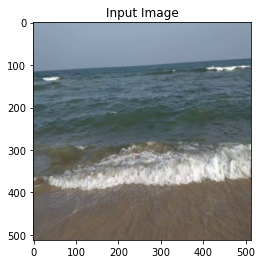

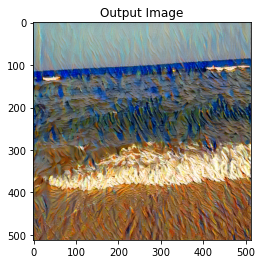

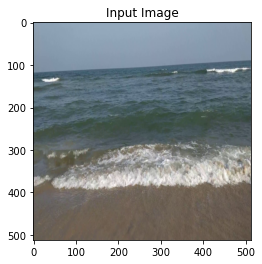

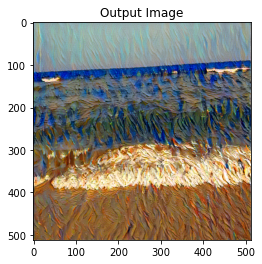

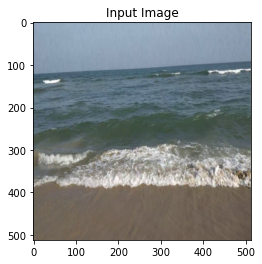

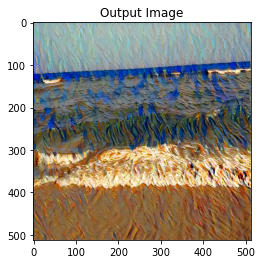

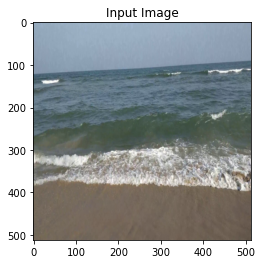

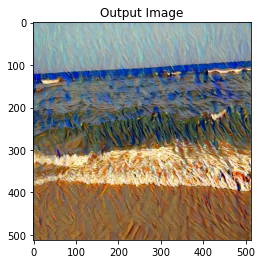

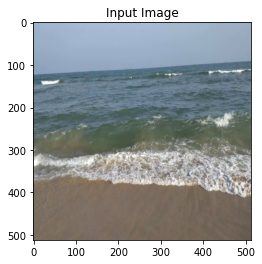

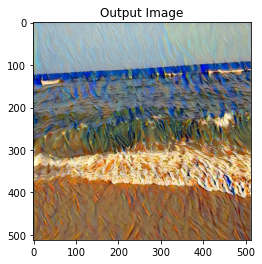

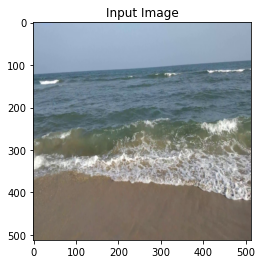

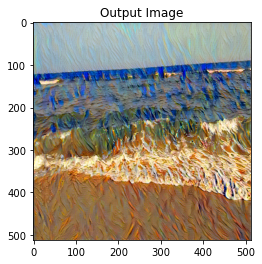

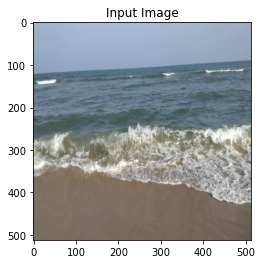

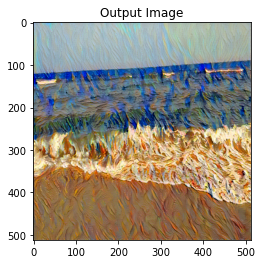

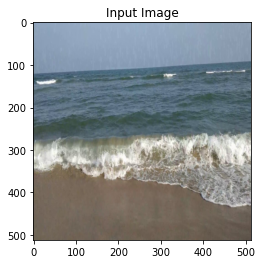

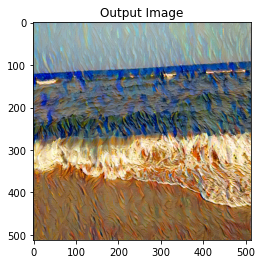

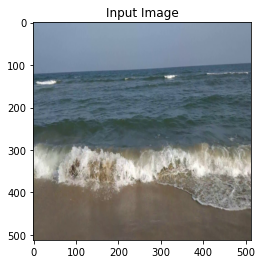

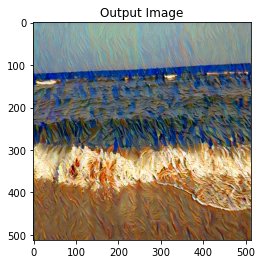

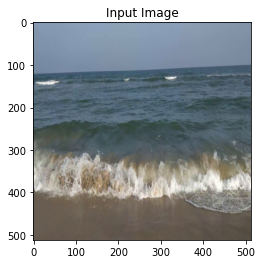

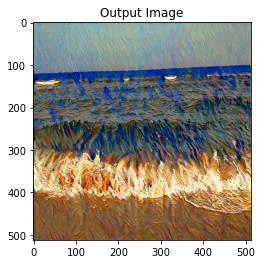

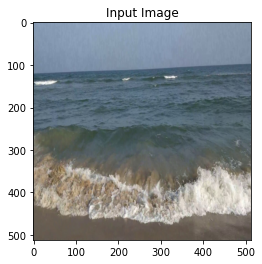

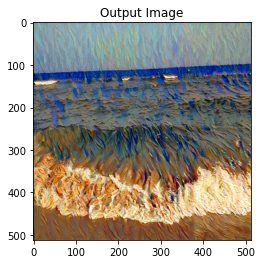

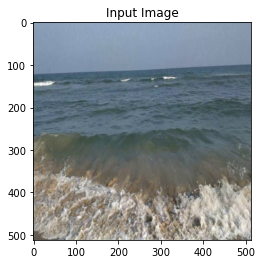

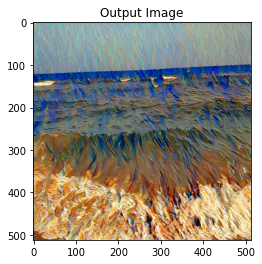

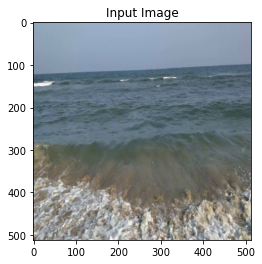

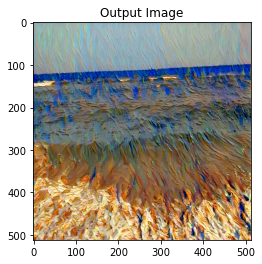

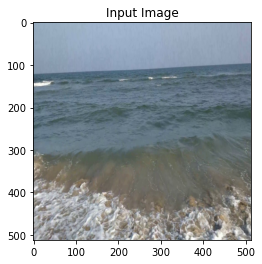

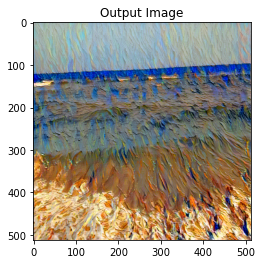

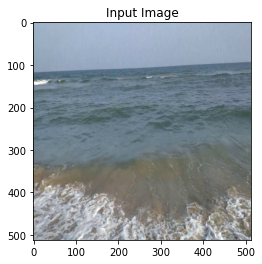

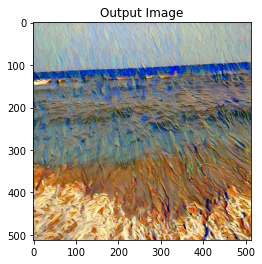

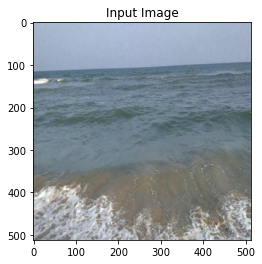

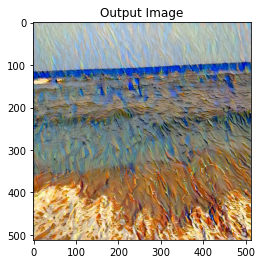

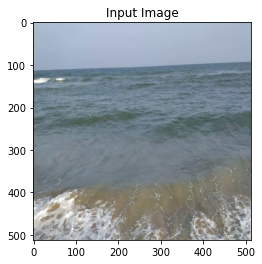

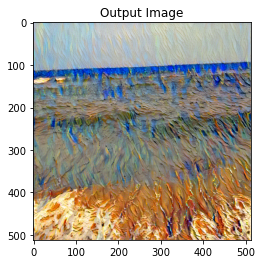

In [12]:
path_modified_output_image = '/notebooks/Notebooks_2019/Style_Data/Video_from_images/'
path_input_image = '/notebooks/Notebooks_2019/Style_Data/Images_from_video/'

Style_image = image_loader('/notebooks/Notebooks_2019/Style_Data/Style15.jpg')

image_files = [file for file in os.listdir(path_input_image) if isfile(join(path_input_image,file))]
for x in range(len(image_files)) :
    input_image_filename = path_input_image+image_files[x]
    output_image_filename = path_modified_output_image+'Modified_'+image_files[x]
    #print(image_filename+' '+output_image_filename)
    image_size_check = Image.open(input_image_filename)
    (height,width) = image_size_check.size
    New_height = 512
    height_percentage = New_height/height
    New_width = width*height_percentage
    print(height,width)
    print(New_height,int(New_width))
    imagesize = (New_height,int(New_width))
    Actual_image = image_loader(input_image_filename)
    input_image = Actual_image.clone()
    plt.figure()
    image_display(input_image,'Input Image')
    output_image = neural_transfer_execute (cnn ,cnn_normalization_mean ,cnn_normalization_std ,Style_image ,Actual_image , input_image)
    plt.figure()
    image_display(output_image,'Output Image')
    output_image = output_image.cpu().clone().squeeze(0)
    output_image_transformation = transforms.Compose([transforms.Resize((height,width))])
    #output_image = output_image_transformation(output_image)
    print(output_image.shape)
    unloader(output_image).save(output_image_filename)

In [13]:
path_input_image = '/notebooks/Notebooks_2019/Style_Data/Video_from_images/'
path_output_image = '/notebooks/Notebooks_2019/Style_Data/final_video.mp4'
frame_Rate = 2
frame_array = []
image_files = [file for file in os.listdir(path_input_image) if isfile(join(path_input_image,file))]
#print(image_files)
image_files.sort(key=lambda x:int(x[15:-4]))
#print(image_files)
for x in range(len(image_files)) :
    image_filename = path_input_image+image_files[x]
    #print(image_filename)
    image = cv2.imread(image_filename)
    h,w,layers = image.shape
    size=(w,h)
    frame_array.append(image)

#print(len(frame_array))    
    
output = cv2.VideoWriter(path_output_image,cv2.VideoWriter_fourcc(*'MJPG'),frame_Rate,size)
for i in range(len(frame_array)) :
    output.write(frame_array[i])
    
output.release()
video.release()
cv2.destroyAllWindows()